#dizionari

In [ ]:
pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 826.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.9 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=6d3bbc0652c6da297ea0a29a05d9dbc8a1ae68e6eb68e49fa0da33f78e3043ea
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()

# Moduli per eseguire il preprocessing dei testi
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from gensim.models.phrases import Phrases
from nltk.corpus import stopwords

from gensim.models.phrases import Phrases
from gensim.models.ldamodel import LdaModel


# Moduli per i modelli vettoriali
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.models import Sequential
from sklearn.model_selection import GridSearchCV

# Moduli per i modelli di classificazione
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
from sklearn.decomposition import TruncatedSVD

from gensim.models import Word2Vec, KeyedVectors
from gensim.utils import simple_preprocess
import gensim.downloader as api

from sentence_transformers import SentenceTransformer

import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#IMPORTO DATI

importiamo i dati e teniamo solo le variabili più utili dalle 20(ricontrollare) iniziali, rendiamo le variabili 'genres', 'keywords' come una lista di valori dato che venivano lette come dizionari

In [ ]:
import json
ordine_colonne=['title','genres','production_companies','release_date','runtime','popularity','budget','revenue','overview','keywords','vote_count','vote_average']
film= pd.read_csv('/content/drive/MyDrive/Tesi/movies.csv')
film= film[ordine_colonne]

In [ ]:
credits = pd.read_csv('/content/drive/MyDrive/Tesi/credits.csv')

In [ ]:
film = film.merge(credits,on='title')

tolgo i dizionari dalle tre variabili successive rendendole liste di valori

In [ ]:
import ast
def convert(obj):
    L = []
    for i in ast.literal_eval(obj):
        L.append(i['name'])
    return L

In [ ]:
film['genres'] = film['genres'].apply(convert)
film['keywords'] = film['keywords'].apply(convert)
film['production_companies'] = film['production_companies'].apply(convert)

estraiamo il direttore dalla crew ed i nomi del cast da cast

In [ ]:
import ast
def convert3(obj):
    L = []
    counter = 0
    for i in ast.literal_eval(obj):
        if counter != 3:
            L.append(i['name'])
            counter+=1
        else:
            break
    return L

In [ ]:
film['cast'] = film['cast'].apply(convert3)

In [ ]:
def fetch_director(obj):
    L = []
    for i in ast.literal_eval(obj):
        if i['job']=='Director':
            L.append(i['name'])
            break
    return L

In [ ]:
film['crew']=film['crew'].apply(fetch_director)

verifichiamo i dati mancanti

In [ ]:
film.isnull().sum()

title                   0
genres                  0
production_companies    0
release_date            1
runtime                 2
popularity              0
budget                  0
revenue                 0
overview                3
keywords                0
vote_count              0
vote_average            0
movie_id                0
cast                    0
crew                    0
dtype: int64

solo tre film non hanno il riassunto, possiamo eliminarli

In [ ]:
film= film.dropna()
film.shape

(4805, 15)

In [ ]:
film.head()

,title,genres,production_companies,release_date,runtime,popularity,budget,revenue,overview,keywords,vote_count,vote_average,movie_id,cast,crew
0,Avatar,"[Action, Adventure, Fantasy, Science Fiction]","[Ingenious Film Partners, Twentieth Century Fo...",2009-12-10,162.0,150.437577,237000000,2787965087,"In the 22nd century, a paraplegic Marine is di...","[culture clash, future, space war, space colon...",11800,7.2,19995,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",[James Cameron]
1,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]","[Walt Disney Pictures, Jerry Bruckheimer Films...",2007-05-19,169.0,139.082615,300000000,961000000,"Captain Barbossa, long believed to be dead, ha...","[ocean, drug abuse, exotic island, east india ...",4500,6.9,285,"[Johnny Depp, Orlando Bloom, Keira Knightley]",[Gore Verbinski]
2,Spectre,"[Action, Adventure, Crime]","[Columbia Pictures, Danjaq, B24]",2015-10-26,148.0,107.376788,245000000,880674609,A cryptic message from Bond’s past sends him o...,"[spy, based on novel, secret agent, sequel, mi...",4466,6.3,206647,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",[Sam Mendes]
3,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]","[Legendary Pictures, Warner Bros., DC Entertai...",2012-07-16,165.0,112.312950,250000000,1084939099,Following the death of District Attorney Harve...,"[dc comics, crime fighter, terrorist, secret i...",9106,7.6,49026,"[Christian Bale, Michael Caine, Gary Oldman]",[Christopher Nolan]
4,John Carter,"[Action, Adventure, Science Fiction]",[Walt Disney Pictures],2012-03-07,132.0,43.926995,260000000,284139100,"John Carter is a war-weary, former military ca...","[based on novel, mars, medallion, space travel...",2124,6.1,49529,"[Taylor Kitsch, Lynn Collins, Samantha Morton]",[Andrew Stanton]


#Analisi descrittive

Vediamo i generi, le case di produzione e i registi più popolari

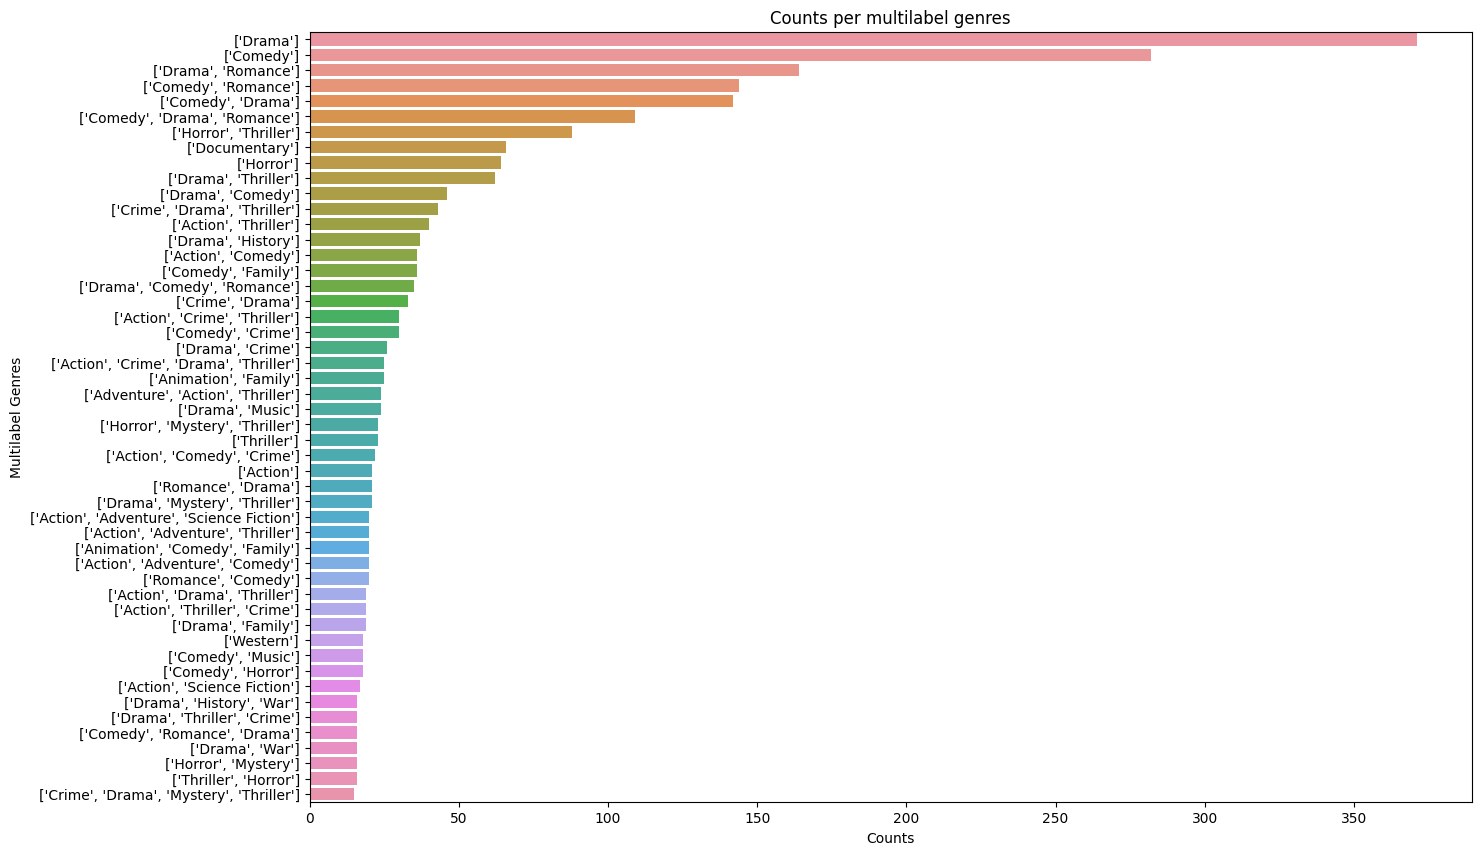

In [ ]:
counts = {}
g = film['genres'].map(str).to_numpy()
for i in g:
    #''.join(map(lambda x: chr(ord(x) + 1), sampleStr))
    #gn = ' '.join(map(lambda x: str(x) + ' |', i))
    if i in counts.keys():
        counts[i] += 1
    else:
        counts[i] = 1
df = pd.DataFrame({"Genre": list(counts.keys()),
                   "Counts": list(counts.values())})
#elimino i valori mancanti per il grafico
df = df.drop(df[df['Genre'] == '['']'].index)
df.drop(columns=['Genre'])
g = df.nlargest(columns=["Counts"], n=50)
plt.figure(figsize=(15,10))
ax = sns.barplot(data=g, x= "Counts", y = "Genre")
ax.set(xlabel = 'Counts', ylabel = 'Multilabel Genres')
plt.title('Counts per multilabel genres')
plt.show()

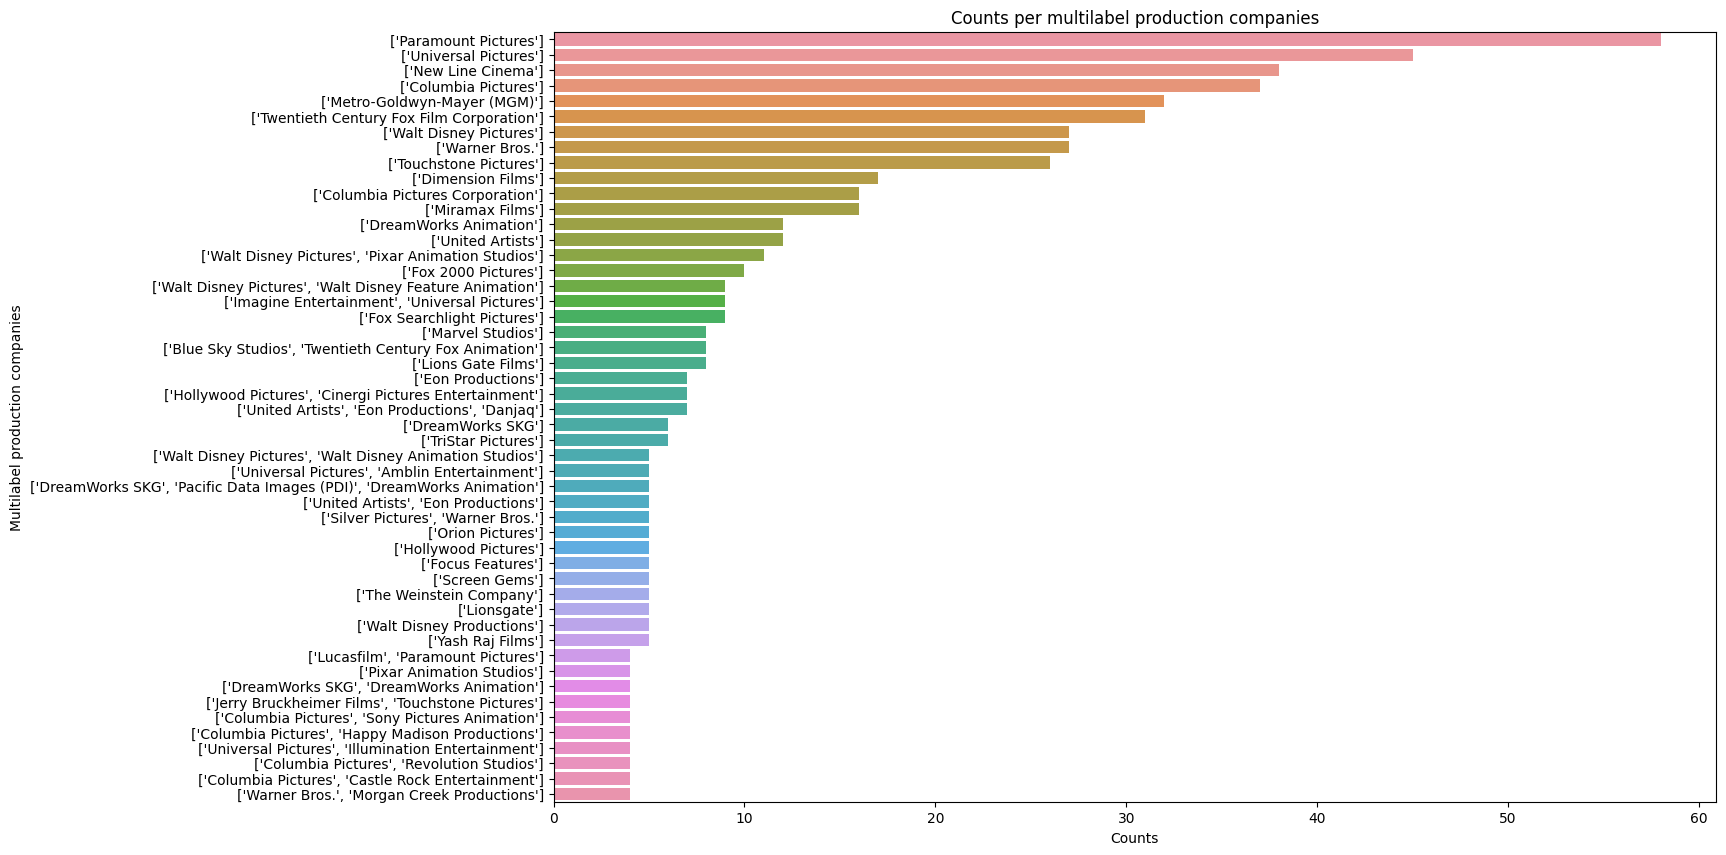

In [ ]:
counts = {}
g = film['production_companies'].map(str).to_numpy()
for i in g:
    #''.join(map(lambda x: chr(ord(x) + 1), sampleStr))
    #gn = ' '.join(map(lambda x: str(x) + ' |', i))
    if i in counts.keys():
        counts[i] += 1
    else:
        counts[i] = 1
df = pd.DataFrame({"production_companies": list(counts.keys()),
                   "Counts": list(counts.values())})
#elimino i valori mancanti per il grafico
df = df.drop(df[df['production_companies'] == '['']'].index)
df.drop(columns=['production_companies'])
g = df.nlargest(columns=["Counts"], n=50)
plt.figure(figsize=(15,10))
ax = sns.barplot(data=g, x= "Counts", y = "production_companies")
ax.set(xlabel = 'Counts', ylabel = 'Multilabel production companies')
plt.title('Counts per multilabel production companies')
plt.show()

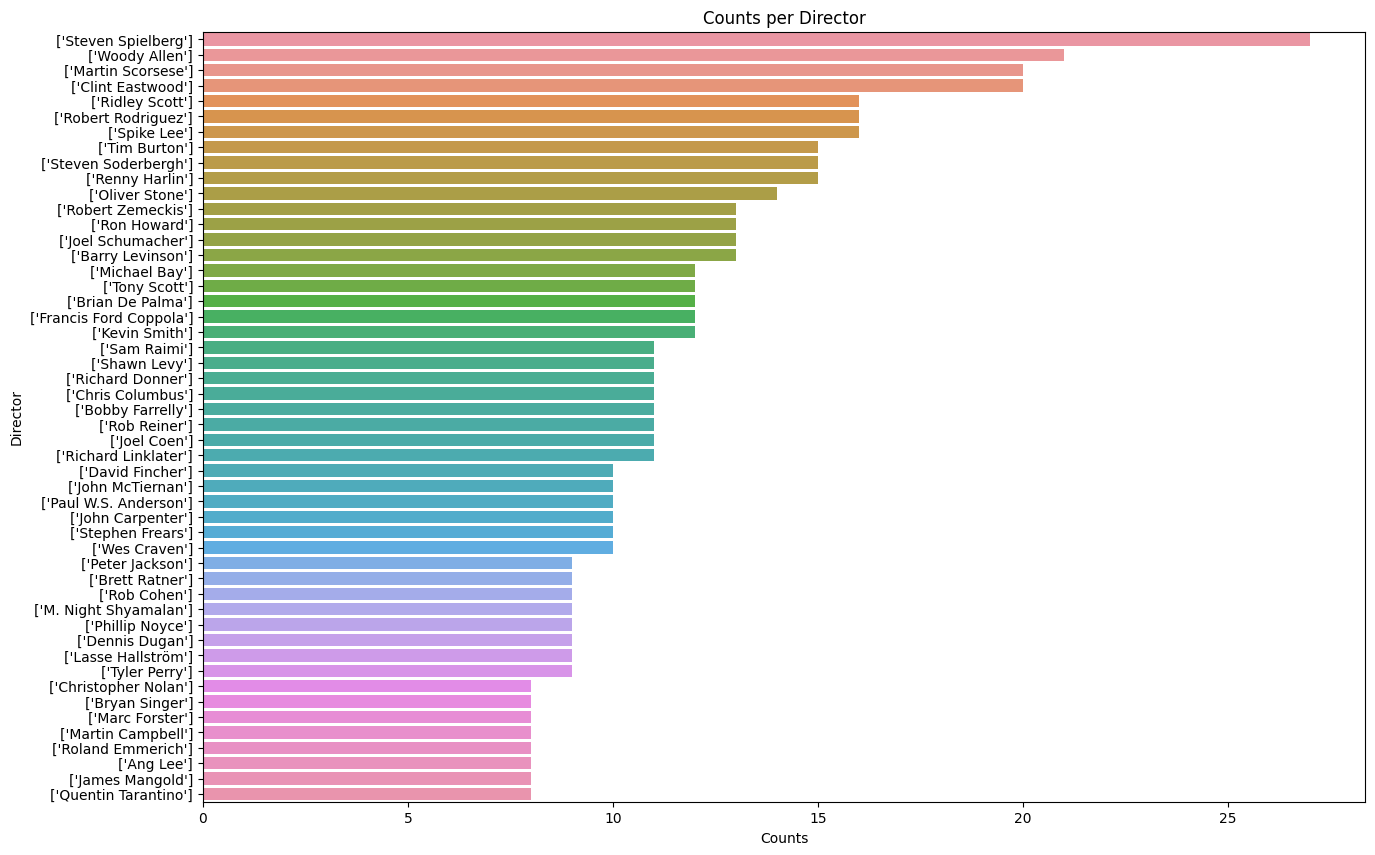

In [ ]:
counts = {}
g = film['crew'].map(str).to_numpy()
for i in g:
    #''.join(map(lambda x: chr(ord(x) + 1), sampleStr))
    #gn = ' '.join(map(lambda x: str(x) + ' |', i))
    if i in counts.keys():
        counts[i] += 1
    else:
        counts[i] = 1
df = pd.DataFrame({"crew": list(counts.keys()),
                   "Counts": list(counts.values())})
#elimino i valori mancanti per il grafico
df = df.drop(df[df['crew'] == '['']'].index)
df.drop(columns=['crew'])
g = df.nlargest(columns=["Counts"], n=50)
plt.figure(figsize=(15,10))
ax = sns.barplot(data=g, x= "Counts", y = "crew")
ax.set(xlabel = 'Counts', ylabel = 'Director')
plt.title('Counts per Director')
plt.show()

Vediamo quali sono le variabili più correlate

<ipython-input-23-dcf7f99d96fe>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(film.corr(), vmin=-0.3, vmax=0.6, center=0, annot=True, fmt='.2f', mask=~np.tri(film.corr().shape[1], k=-1, dtype=bool), cbar=True, cmap='coolwarm')


<Axes: >

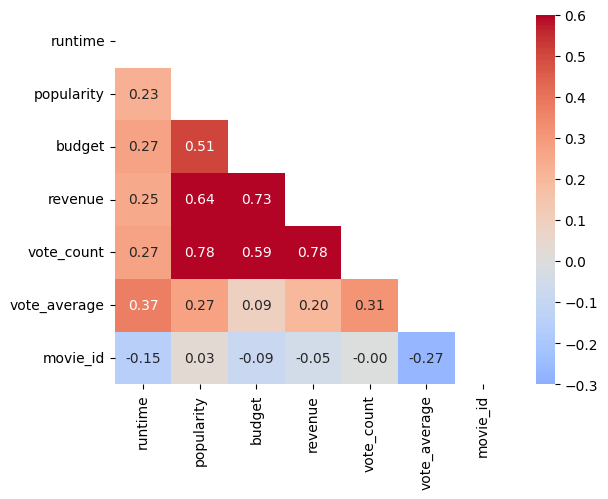

In [ ]:
sns.heatmap(film.corr(), vmin=-0.3, vmax=0.6, center=0, annot=True, fmt='.2f', mask=~np.tri(film.corr().shape[1], k=-1, dtype=bool), cbar=True, cmap='coolwarm')

#Pulizia testi

In questa fase andiamo a pulire i testi cercando di mantenere solo le parole che riteniamo più utili per il modello. Andiamo a:

1) rimuoviamo i caratteri non alfa-numerici, i caratteri minuscoli e le parole con meno di due caratteri

2) rimuoviamo le stopwords

3) creiamo degli n-gramms

1) rimuoviamo i caratteri non alfa-numerici, i caratteri minuscoli e le parole con meno di due caratteri

In [ ]:
data = film
# Usiamo le espessioni regolari per eliminari tutti i carattere non alfa-numerici
# \d tiene anche i caratteri numerici
data['clear_text'] = data['overview'].str.lower().str.replace('[^\w\s\d]',' ', regex=True)
data['clear_text'] = data['clear_text'].str.split()

Creiamo una nuova variabile dopo ogni passaggio di pulizia per verificare quanto diminuiscono le dimensioni dei testi.

In [ ]:
data['len_parole'] = data.clear_text.str.len()

In [ ]:
data['clear_text'] = data['clear_text'].progress_apply(lambda x: [word for word in x if len(word) > 2])
data['len_parole_caratteri'] = data.clear_text.str.len()
data.head()

100%|██████████| 4805/4805 [00:00<00:00, 51017.85it/s]


,title,genres,production_companies,release_date,runtime,popularity,budget,revenue,overview,keywords,vote_count,vote_average,movie_id,cast,crew,clear_text,len_parole,len_parole_caratteri
0,Avatar,"[Action, Adventure, Fantasy, Science Fiction]","[Ingenious Film Partners, Twentieth Century Fo...",2009-12-10,162.0,150.437577,237000000,2787965087,"In the 22nd century, a paraplegic Marine is di...","[culture clash, future, space war, space colon...",11800,7.2,19995,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",[James Cameron],"[the, 22nd, century, paraplegic, marine, dispa...",28,21
1,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]","[Walt Disney Pictures, Jerry Bruckheimer Films...",2007-05-19,169.0,139.082615,300000000,961000000,"Captain Barbossa, long believed to be dead, ha...","[ocean, drug abuse, exotic island, east india ...",4500,6.9,285,"[Johnny Depp, Orlando Bloom, Keira Knightley]",[Gore Verbinski],"[captain, barbossa, long, believed, dead, has,...",34,25
2,Spectre,"[Action, Adventure, Crime]","[Columbia Pictures, Danjaq, B24]",2015-10-26,148.0,107.376788,245000000,880674609,A cryptic message from Bond’s past sends him o...,"[spy, based on novel, secret agent, sequel, mi...",4466,6.3,206647,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",[Sam Mendes],"[cryptic, message, from, bond, past, sends, hi...",42,32
3,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]","[Legendary Pictures, Warner Bros., DC Entertai...",2012-07-16,165.0,112.312950,250000000,1084939099,Following the death of District Attorney Harve...,"[dc comics, crime fighter, terrorist, secret i...",9106,7.6,49026,"[Christian Bale, Michael Caine, Gary Oldman]",[Christopher Nolan],"[following, the, death, district, attorney, ha...",68,57
4,John Carter,"[Action, Adventure, Science Fiction]",[Walt Disney Pictures],2012-03-07,132.0,43.926995,260000000,284139100,"John Carter is a war-weary, former military ca...","[based on novel, mars, medallion, space travel...",2124,6.1,49529,"[Taylor Kitsch, Lynn Collins, Samantha Morton]",[Andrew Stanton],"[john, carter, war, weary, former, military, c...",58,43


2) rimuoviamo le stopwords

In [ ]:
# Rimuoviamo le stopwords e ricostruiamo il testo
stop = stopwords.words('english')
stop.extend(['good', 'bad', 'dont', 'many', 'excellent', 'would', 'perfect', 'even', 'great','nice', 'amazing'])
data['clear_text'] = data['clear_text'].progress_apply(lambda x: ' '.join([item for item in x if item not in stop]))

100%|██████████| 4805/4805 [00:01<00:00, 4670.38it/s]


In [ ]:
data['clear_text'] = data['clear_text'].str.split()

In [ ]:
data['len_parole_stop'] = data.clear_text.str.len()

3) creiamo gli ngrams

In [ ]:
bigram_model = Phrases(data['clear_text'], min_count=10, threshold=0.5)
data['clear_text'] = data['clear_text'].progress_apply(lambda x: bigram_model[bigram_model[x]])

# min_count=10 significa che gli n-grammi (in questo caso bigrammi) che compaiono meno di 10 volte
# nel corpus di testo saranno scartati.

# threshold=0.5 significa che i bigrammi che hanno una frequenza di co-occorrenza superiore al 50%
# rispetto alla loro singola frequenza verranno considerati come unico termine.

100%|██████████| 4805/4805 [00:00<00:00, 7713.57it/s]


In [ ]:
data['len_parole_ngram'] = data.clear_text.str.len()

In [ ]:
# Controllo se qualche testo è diventato vuoto durante il processo di pulizia
data[data['clear_text'].isna()]

,title,genres,production_companies,release_date,runtime,popularity,budget,revenue,overview,keywords,vote_count,vote_average,movie_id,cast,crew,clear_text,len_parole,len_parole_caratteri,len_parole_stop,len_parole_ngram


In [ ]:
data.head()

,title,genres,production_companies,release_date,runtime,popularity,budget,revenue,overview,keywords,vote_count,vote_average,movie_id,cast,crew,clear_text,len_parole,len_parole_caratteri,len_parole_stop,len_parole_ngram
0,Avatar,"[Action, Adventure, Fantasy, Science Fiction]","[Ingenious Film Partners, Twentieth Century Fo...",2009-12-10,162.0,150.437577,237000000,2787965087,"In the 22nd century, a paraplegic Marine is di...","[culture clash, future, space war, space colon...",11800,7.2,19995,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",[James Cameron],"[22nd, century, paraplegic, marine, dispatched...",28,21,16,16
1,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]","[Walt Disney Pictures, Jerry Bruckheimer Films...",2007-05-19,169.0,139.082615,300000000,961000000,"Captain Barbossa, long believed to be dead, ha...","[ocean, drug abuse, exotic island, east india ...",4500,6.9,285,"[Johnny Depp, Orlando Bloom, Keira Knightley]",[Gore Verbinski],"[captain, barbossa, long, believed, dead, come...",34,25,17,17
2,Spectre,"[Action, Adventure, Crime]","[Columbia Pictures, Danjaq, B24]",2015-10-26,148.0,107.376788,245000000,880674609,A cryptic message from Bond’s past sends him o...,"[spy, based on novel, secret agent, sequel, mi...",4466,6.3,206647,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",[Sam Mendes],"[cryptic, message, bond, past, sends, trail, u...",42,32,26,24
3,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]","[Legendary Pictures, Warner Bros., DC Entertai...",2012-07-16,165.0,112.312950,250000000,1084939099,Following the death of District Attorney Harve...,"[dc comics, crime fighter, terrorist, secret i...",9106,7.6,49026,"[Christian Bale, Michael Caine, Gary Oldman]",[Christopher Nolan],"[following, death, district_attorney, harvey, ...",68,57,44,42
4,John Carter,"[Action, Adventure, Science Fiction]",[Walt Disney Pictures],2012-03-07,132.0,43.926995,260000000,284139100,"John Carter is a war-weary, former military ca...","[based on novel, mars, medallion, space travel...",2124,6.1,49529,"[Taylor Kitsch, Lynn Collins, Samantha Morton]",[Andrew Stanton],"[john, carter, war, weary, former, military, c...",58,43,31,31


In [ ]:
data= data.drop(columns=['len_parole',	'len_parole_stop',	'len_parole_caratteri', 'len_parole_ngram'])

#Creazione recommender system basato sul contenuto, parole chiave, cast, direttore e generi (che chiameremo 'tags')

In [ ]:
data['genres']=data['genres'].apply(lambda x:[i.replace(' ','') for i in x])
data['keywords']=data['keywords'].apply(lambda x:[i.replace(' ','') for i in x])
data['cast']=data['cast'].apply(lambda x:[i.replace(' ','') for i in x])
data['crew']=data['crew'].apply(lambda x:[i.replace(' ','') for i in x])

In [ ]:
data['tags'] = data['clear_text'] + data['genres'] + data['keywords'] + data['cast'] + data['crew']

In [ ]:
new_df = data[['movie_id','title','tags']]

tolgo la lista e tengo una stringa unica

In [ ]:
new_df['tags'] = new_df['tags'].apply(lambda x:' '.join(x))

rendo i caratteri minuscoli

In [ ]:
new_df['tags'] = new_df['tags'].apply(lambda x:x.lower())

creo un nuovo csv con i dati del dataframe new_df, questo velocizzerà i tempi ogni volta che aprirò colab

In [ ]:
new_df.to_csv('/content/drive/MyDrive/Tesi/dati.csv', index=False)

#  ri-importo i dati

In [ ]:
new_df= pd.read_csv('/content/drive/MyDrive/Tesi/dati.csv')
new_df.head()

,movie_id,title,tags
0,19995,Avatar,22nd century paraplegic marine dispatched moon...
1,285,Pirates of the Caribbean: At World's End,captain barbossa long believed dead come back ...
2,206647,Spectre,cryptic message bond past sends trail uncover ...
3,49026,The Dark Knight Rises,following death district_attorney harvey dent ...
4,49529,John Carter,john carter war weary former military captain ...


#Count vectorizer

In [ ]:
cv = CountVectorizer(max_features = 5000,stop_words = 'english')

In [ ]:
vectors = cv.fit_transform(new_df['tags']).toarray()

In [ ]:
similarity = cosine_similarity(vectors)

In [ ]:
def recommend(movie):
    movie_index = new_df[new_df['title'] == movie].index[0]
    distances = similarity[movie_index]
    movies_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x: x[1])[1:11]

    recommended_movies = []

    for i in movies_list:
        recommended_movies.append((new_df.iloc[i[0]].title, i[1]))

    return recommended_movies

In [ ]:
recommendations = recommend("The Lord of the Rings: The Fellowship of the Ring")
for movie, similarity_score in recommendations:
    print(f"{movie};{similarity_score}")

The Lord of the Rings: The Two Towers;0.4411287732562847
The Hobbit: An Unexpected Journey;0.4216370213557839
The Hobbit: The Desolation of Smaug;0.40408541690413596
The Hobbit: The Battle of the Five Armies;0.36874092283506865
The Lord of the Rings: The Return of the King;0.3431001569771103
The Addams Family;0.2065932622669707
What's the Worst That Could Happen?;0.1987615979999813
Warcraft;0.18090680674665818
Eragon;0.17888543819998318
Beastmaster 2: Through the Portal of Time;0.1763834207376394


Ora lo faccio inserendo una descrizione di un film e non il titolo

In [ ]:
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Scarica le stopwords in lingua inglese
nltk.download('stopwords')
from nltk.corpus import stopwords

# Esegui il pre-processing sulla frase inserita
frase = "space explorer travels around universe"
frase = frase.lower()
frase = re.sub(r'[^\w\s\d]', ' ', frase)
frase = re.sub(r'\s+', ' ', frase)
frase = frase.split()

# Rimuovi le stopwords e le parole con lunghezza inferiore a 2
stop = set(stopwords.words('english'))
frase = [word for word in frase if len(word) > 2 and word not in stop]

# Crea gli n-gram
ngram_range = (1, 2)  # Modifica il range per gli n-gram desiderati
cv = CountVectorizer(max_features=5000, stop_words='english', ngram_range=ngram_range)
vectors = cv.fit_transform(new_df['tags']).toarray()

input_vector = cv.transform([' '.join(frase)]).toarray()

# Calcola la similarità tra la frase inserita e le tags dei film
similarities = cosine_similarity(input_vector, vectors)

# Trova i film con le tags più simili
similar_movies_indices = similarities[0].argsort()[::-1][:10]

recommended_movies = []

for movie_index in similar_movies_indices:
    recommended_movies.append((new_df.iloc[movie_index]['title'], similarities[0][movie_index]))

# Stampa i film raccomandati
for movie, similarity_score in recommended_movies:
    print(f"{movie}; {similarity_score}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Space Pirate Captain Harlock; 0.2886751345948129
Lost in Space; 0.25197631533948484
Space Chimps; 0.25000000000000006
Jupiter Ascending; 0.24077170617153845
Gravity; 0.2254938084008487
Super Mario Bros.; 0.22222222222222227
You Only Live Twice; 0.2182178902359924
Treasure Planet; 0.2100420126042015
Ender's Game; 0.20739033894608508
Land of the Lost; 0.20739033894608508


#tf-idf

In [ ]:
# Supponendo che tu abbia già creato 'new_df' e 'cosine_similarity' come indicato nel tuo codice.

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(new_df['tags'])
cosine_similarity = linear_kernel(tfidf_matrix, tfidf_matrix)
# sklearn TF-IDF defaults to using L2 Norm, for which linear kernel == cosine similarity

indices = pd.Series(new_df.index, index=new_df['title']).drop_duplicates()

def recommenda(title, similarity_matrix, topk=10):
    movie_index = indices[title]
    # enumerate here adds index of book being referenced by similarity score,
    # allows reverse lookup once sorted by similarity score
    similarity_scores = list(enumerate(similarity_matrix[movie_index]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    top_scores = similarity_scores[1:topk+1]  # Escludi il film di riferimento
    recommendation_indices = [i[0] for i in top_scores]

    # Estrai i titoli e le similarità dei film consigliati
    recommendations = [(new_df['title'].iloc[i], similarity_scores[i][1]) for i in recommendation_indices]

    return recommendations

# Esempio di utilizzo:
recs = recommenda('The Lord of the Rings: The Fellowship of the Ring', cosine_similarity)
recs = sorted(recs, key=lambda x: x[1], reverse=True)
# Stampa i titoli dei film consigliati e le relative similarità
for rec_title, similarity in recs:
    print(f"{rec_title};{similarity}")

The Hobbit: The Battle of the Five Armies;0.0649044158428312
The Hobbit: The Desolation of Smaug;0.06310647585664046
The Hobbit: An Unexpected Journey;0.03820667222305578
Warcraft;0.037262035059424964
The Lord of the Rings: The Return of the King;0.02422077120667703
The Lord of the Rings: The Two Towers;0.024140881738085106
The Lion King;0.019751471645446873
The Addams Family;0.008043085754667762
What's the Worst That Could Happen?;0.0076976948350270386
Darling Lili;0.005455221986327784


Ora lo faccio inserendo una descrizione di un film e non il titolo

In [ ]:
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Scarica le stopwords in lingua inglese
nltk.download('stopwords')
from nltk.corpus import stopwords

# Esegui il pre-processing sulla frase inserita
frase = "space explorer travels around universe"
frase = frase.lower()
frase = re.sub(r'[^\w\s\d]', ' ', frase)
frase = re.sub(r'\s+', ' ', frase)
frase = frase.split()

# Rimuovi le stopwords e le parole con lunghezza inferiore a 2
stop = set(stopwords.words('english'))
frase = [word for word in frase if len(word) > 2 and word not in stop]

# Calcola il vettore di features per la frase
frase = ' '.join(frase)  # Unisci le parole in una stringa
tfidf_matrix_frase = tfidf.transform([frase])
cosine_sim_frase = linear_kernel(tfidf_matrix_frase, tfidf_matrix).flatten()

# Ordina i film in base alla similarità
movie_indices_sorted = cosine_sim_frase.argsort()[::-1]

# Elenca i primi 10 film raccomandati (escludendo il film di riferimento)
top_k = 10
recommended_movies = [(new_df['title'].iloc[idx], cosine_sim_frase[idx]) for idx in movie_indices_sorted[1:top_k + 1]]

# Stampa i film raccomandati
for movie, similarity_score in recommended_movies:
    print(f"{movie};{similarity_score}")

Super Mario Bros.;0.15347419787116498
Jupiter Ascending;0.14897068485403991
Space Pirate Captain Harlock;0.1483958662737552
Two Brothers;0.1278532801660742
Land of the Lost;0.12631930980189693
Space Chimps;0.12482793503296305
You Only Live Twice;0.12153035341108606
Alien;0.12131948512970275
Treasure Planet;0.12052520186652618
Gravity;0.11451759898502105


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#Bags of words and LSA

In [ ]:
# Create bag of words
vectorizer = CountVectorizer()
bow = vectorizer.fit_transform(new_df['tags'])

# Convert bag of words to TF-IDF
tfidf_transformer = TfidfTransformer()
tfidf = tfidf_transformer.fit_transform(bow)

In [ ]:
# Apply LSA or LSI
lsa = TruncatedSVD(n_components=300, algorithm='arpack')
lsa.fit(tfidf)

TruncatedSVD(algorithm='arpack', n_components=300)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
# Get the user input
user_movie = "The Lord of the Rings: The Fellowship of the Ring"

# Find the index of the user movie
movie_index = new_df[new_df['title'] == user_movie].index[0]

# Compute the cosine similarities between the user movie and all other movies
similarity_scores = cosine_similarity(tfidf[movie_index], tfidf)

# Get the top 10 most similar movies
similar_movies = list(enumerate(similarity_scores[0]))
sorted_similar_movies = sorted(similar_movies, key=lambda x: x[1], reverse=True)[1:11]

# Print the top 10 similar movies with their similarity scores
for i, score in sorted_similar_movies:
    print(f"{new_df.loc[i, 'title']};{score}")
    #print("{}: {} (Similarity Score: {})".format(i, new_df.loc[i, 'title'], score))

The Hobbit: An Unexpected Journey;0.3921151659124042
The Hobbit: The Desolation of Smaug;0.3764847140904179
The Lord of the Rings: The Two Towers;0.36907404041013986
The Hobbit: The Battle of the Five Armies;0.3265597805546848
The Lord of the Rings: The Return of the King;0.2846722636568062
The Addams Family;0.10943776150643636
What's the Worst That Could Happen?;0.10392163687536217
Warcraft;0.09230191079665037
The Lion King;0.07521393936240532
Darling Lili;0.07351856028562992


Ora lo faccio inserendo una descrizione di un film e non il titolo

In [ ]:
import re
import nltk
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

# Scarica le stopwords in lingua inglese
nltk.download('stopwords')
from nltk.corpus import stopwords

# Esegui il pre-processing sulla frase inserita
frase = "a hobbit who sets out on a perilous quest to destroy the One Ring and prevent the Dark Lord Sauron from conquering Middle-earth. With a fellowship of companions, including Gandalf, Aragorn, and Legolas, they face daunting challenges and confront the forces of evil. Through their trials and sacrifices, they strive to save their world from darkness and restore peace."
frase = frase.lower()
frase = re.sub(r'[^\w\s\d]', ' ', frase)
frase = re.sub(r'\s+', ' ', frase)
frase = frase.split()

# Rimuovi le stopwords e le parole con lunghezza inferiore a 2
stop = set(stopwords.words('english'))
frase = [word for word in frase if len(word) > 2 and word not in stop]

# Unisci le parole in una stringa
frase = ' '.join(frase)

# Create bag of words
vectorizer = CountVectorizer()
bow = vectorizer.fit_transform(new_df['tags'])

# Convert bag of words to TF-IDF
tfidf_transformer = TfidfTransformer()
tfidf = tfidf_transformer.fit_transform(bow)

# Apply LSA or LSI
lsa = TruncatedSVD(n_components=300, algorithm='arpack')
lsa.fit(tfidf)

# Calcola il vettore TF-IDF per la frase inserita
frase_tfidf = tfidf_transformer.transform(vectorizer.transform([frase]))

# Calcola il vettore di features ridotte per la frase inserita usando LSA
frase_lsa = lsa.transform(frase_tfidf)

# Calcola la similarità tra la frase inserita e i film basati su LSA
similarity_scores = cosine_similarity(frase_lsa, lsa.transform(tfidf))

# Trova i 10 film più simili
similar_movies = list(enumerate(similarity_scores[0]))
sorted_similar_movies = sorted(similar_movies, key=lambda x: x[1], reverse=True)[:10]

# Stampa i film raccomandati
print("Raccomandazioni basate su LSA:")
for i, score in sorted_similar_movies:
  print(f"{new_df.loc[i, 'title']};{score}")
    #print("{}: {} (Similarity Score: {})".format(i, new_df.loc[i, 'title'], score))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Raccomandazioni basate su LSA:
The Lord of the Rings: The Return of the King;0.7631540451949617
The Lord of the Rings: The Two Towers;0.6882096550722425
The Hobbit: The Battle of the Five Armies;0.6748651013628062
The Lord of the Rings: The Fellowship of the Ring;0.6648509711333219
The Hobbit: An Unexpected Journey;0.6575435259602342
The Hobbit: The Desolation of Smaug;0.5758738760979523
Warcraft;0.3666219371968116
2012;0.3624992816991386
Battlefield Earth;0.29813338761552344
Space Battleship Yamato;0.29625117994364125


# Word2vec

In [ ]:
# Tokenize content for Word2Vec
new_df['tokenized_content'] = new_df['tags'].apply(simple_preprocess)

# Load the pre-trained Word2Vec model (Google News)
model = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
# Function to average word vectors for a text
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.

    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector

# Function to compute average word vectors for all movies
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.index_to_key)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features) for tokenized_sentence in corpus]
    return np.array(features)

# Compute average word vectors for all movies
w2v_feature_array = averaged_word_vectorizer(corpus=new_df['tokenized_content'], model=model, num_features=300)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
# Get the user input
user_movie = "The Lord of the Rings: The Fellowship of the Ring"

# Find the index of the user movie
movie_index = new_df[new_df['title'] == user_movie].index[0]

# Compute the cosine similarities between the user movie and all other movies
user_movie_vector = w2v_feature_array[movie_index].reshape(1, -1)
similarity_scores = cosine_similarity(user_movie_vector, w2v_feature_array)

# Get the top 10 most similar movies
similar_movies = list(enumerate(similarity_scores[0]))
sorted_similar_movies = sorted(similar_movies, key=lambda x: x[1], reverse=True)[1:11]

# Print the top 10 similar movies
for i, score in sorted_similar_movies:
  print(f"{new_df.loc[i, 'title']};{score}")
  #  print("{}: {} (Similarity Score: {})".format(i, new_df.loc[i, 'title'], score))

The Lord of the Rings: The Two Towers;0.8776250567690311
The Hobbit: An Unexpected Journey;0.8682427961511185
The Hobbit: The Battle of the Five Armies;0.8603069565271002
The Secret of Kells;0.8577085129787387
Dragon Nest: Warriors' Dawn;0.842594661527067
The Lord of the Rings: The Return of the King;0.8393583165926877
Casper;0.8327528241693142
The Wizard of Oz;0.8312448680805553
How to Train Your Dragon 2;0.8299166560716716
The Chronicles of Narnia: The Lion, the Witch and the Wardrobe;0.8282313192145228


Ora lo faccio inserendo una descrizione di un film e non il titolo

In [ ]:
import re
import nltk
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity

# Scarica le stopwords in lingua inglese
nltk.download('stopwords')
from nltk.corpus import stopwords

# Esegui il pre-processing sulla frase inserita
frase = "space explorer travels around universe"
frase = frase.lower()
frase = re.sub(r'[^\w\s\d]', ' ', frase)
frase = re.sub(r'\s+', ' ', frase)
frase = frase.split()

# Rimuovi le stopwords e le parole con lunghezza inferiore a 2
stop = set(stopwords.words('english'))
frase = [word for word in frase if len(word) > 2 and word not in stop]

# Calcola il vettore di features per la frase inserita
frase_vector = np.mean([model[word] for word in frase if word in model], axis=0)

# Calcola la similarità tra la frase inserita e i film basati su Word2Vec
similarity_scores = cosine_similarity([frase_vector], w2v_feature_array)

# Trova i 10 film più simili
similar_movies = list(enumerate(similarity_scores[0]))
sorted_similar_movies = sorted(similar_movies, key=lambda x: x[1], reverse=True)[:10]

# Stampa i film raccomandati
print("Raccomandazioni basate su Word2Vec:")
for i, score in sorted_similar_movies:
  print(f"{new_df.loc[i, 'title']};{score}")
    #print("{}: {} (Similarity Score: {})".format(i, new_df.loc[i, 'title'], score))


Raccomandazioni basate su Word2Vec:
Interstellar;0.7305768090156332
2001: A Space Odyssey;0.6923148068699327
Lost in Space;0.6664921836629831
Prometheus;0.6522360304105712
Sea Rex 3D: Journey to a Prehistoric World;0.6478079786503796
Guardians of the Galaxy;0.640347927359559
Stargate: The Ark of Truth;0.6291034632358231
Deep Impact;0.6227439406165036
Treasure Planet;0.6225026113643526
Meet Dave;0.616241850624431


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# BERT

In [ ]:
bert= SentenceTransformer('all-mpnet-base-v1')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


.gitattributes:   0%|          | 0.00/737 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/9.85k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/591 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/15.7k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [ ]:
sentence_embeddings= bert.encode(new_df['tags'].tolist())

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
# Get the user input
user_movie = "The Lord of the Rings: The Fellowship of the Ring"

# Find the index of the user movie
movie_index = new_df[new_df['title'] == user_movie].index[0]

similarity_scores = cosine_similarity([sentence_embeddings[movie_index]], sentence_embeddings)

# Get the top 10 most similar movies
similar_movies = list(enumerate(similarity_scores[0]))
sorted_similar_movies = sorted(similar_movies, key=lambda x: x[1], reverse=True)[1:11]

# Print the top 10 similar movies
for i, score in sorted_similar_movies:
  print(f"{new_df.loc[i, 'title']};{score}")
    #print("{}: {} (Similarity Score: {})".format(i, new_df.loc[i, 'title'], score))

The Lord of the Rings: The Two Towers;0.7833250761032104
The Hobbit: An Unexpected Journey;0.7675470113754272
The Lord of the Rings: The Return of the King;0.7165331840515137
The Hobbit: The Battle of the Five Armies;0.7155429720878601
The Hobbit: The Desolation of Smaug;0.6948899030685425
The Chronicles of Narnia: The Lion, the Witch and the Wardrobe;0.5894360542297363
The Chronicles of Narnia: The Voyage of the Dawn Treader;0.5341454148292542
Harry Potter and the Philosopher's Stone;0.5103380680084229
The NeverEnding Story;0.5086168646812439
The Secret of Kells;0.5041003227233887


Ora lo faccio inserendo una descrizione di un film e non il titolo

In [ ]:
import re
import nltk
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Scarica le stopwords in lingua inglese
nltk.download('stopwords')
from nltk.corpus import stopwords

# Esegui il pre-processing sulla frase inserita
frase = "space explorer travels around universe"
frase = frase.lower()
frase = re.sub(r'[^\w\s\d]', ' ', frase)
frase = re.sub(r'\s+', ' ', frase)
frase = frase.split()

# Rimuovi le stopwords e le parole con lunghezza inferiore a 2
stop = set(stopwords.words('english'))
frase = [word for word in frase if len(word) > 2 and word not in stop]

# Calcola il vettore di features per la frase inserita
frase = ' '.join(frase)  # Unisci le parole in una stringa

# Carica il modello BERT
bert = SentenceTransformer('all-mpnet-base-v1')
frase_embedding = bert.encode([frase])

# Calcola la similarità tra la frase inserita e i film basati su BERT
similarity_scores = cosine_similarity(frase_embedding, sentence_embeddings)

# Trova i 10 film più simili
similar_movies = list(enumerate(similarity_scores[0]))
sorted_similar_movies = sorted(similar_movies, key=lambda x: x[1], reverse=True)[:10]

# Stampa i film raccomandati
print("Raccomandazioni basate su BERT:")
for i, score in sorted_similar_movies:
  print(f"{new_df.loc[i, 'title']};{score}")
  #print("{}: {} (Similarity Score: {})".format(i, new_df.loc[i, 'title'], score))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Raccomandazioni basate su BERT:
Interstellar;0.4835568070411682
The Black Hole;0.45050716400146484
Stargate: The Ark of Truth;0.4404332637786865
Star Trek IV: The Voyage Home;0.43363821506500244
Treasure Planet;0.40753820538520813
Star Trek: The Motion Picture;0.386948823928833
Prometheus;0.3825451135635376
Star Trek;0.38247746229171753
Escape from Planet Earth;0.36666738986968994
Star Trek: Generations;0.3646172285079956
